In [1]:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
import QuantLib as ql

from BS import *

# https://quant.stackexchange.com/questions/44957/numerical-simulation-of-heston-model

In [2]:
theta = 0.132328; kappa = 10.980797; sigma = 1.7; rho = -0.351560; v0 = 0.065690
#spot, K = 659.37, 758.28
spot, K = 659.37, 600.0

theta = 0.05; kappa = 0.3; sigma = 0.5; rho = -0.6; v0 = 0.04
# theta = 0.05; kappa = 0.3; sigma = 0.1; rho = -0.6; v0 = 0.04
sigma_lv = 1.0; beta_lv = 1.5; # slv params
r = 0.0 # always presume zero risk-free interest
spot, K = 1.0, 1.0
spot, K = 1.0, 1.5

In [3]:
feller_cond = 2*kappa*theta > sigma**2
print("Feller condition is ", feller_cond)

Feller condition is  False


# Validation using Monte-Carlo simulation

In [4]:
def get_leverage(t,S,sigma_lv,beta_lv):
    return sigma_lv*np.power(S,beta_lv-1)

lev_func = lambda t,S: get_leverage(t,S,sigma_lv,beta_lv)

def HeMC (S0, mu, v0, rho, kappa, theta, sigma, T, dt):
    xi = sigma

    # Generate a Monte Carlo simulation for the Heston model

    # Generate random Brownian Motion
    MU  = np.array([0, 0])
    COV = np.matrix([[1, rho], [rho, 1]])
    W   = np.random.multivariate_normal(MU, COV, T)
    W_S = W[:,0]
    W_v = W[:,1]

    # Generate paths
    vt    = np.zeros(T)
    vt[0] = v0
    St    = np.zeros(T)
    St[0] = S0
    for t in range(1,T):
        lev = lev_func(t,St[t-1])
#         lev = 1.0
#        vt[t] = (vt[t-1] + kappa*(theta-(vt[t-1]))*dt + xi*np.sqrt(dt*vt[t-1])*W_v[t])
        vt[t] = max(0.0,vt[t-1] + kappa*(theta-(vt[t-1]))*dt + xi*np.sqrt(dt*vt[t-1])*W_v[t])
#        vt[t] = np.abs(vt[t-1] + kappa*(theta-(vt[t-1]))*dt + xi*np.sqrt(dt*vt[t-1])*W_v[t])
        St[t] = St[t-1]*np.exp((mu - 0.5*(lev**2)*vt[t-1])*dt + lev*np.sqrt(vt[t-1]*dt)*W_S[t])

    return St, vt

In [5]:
num_paths = 20000
S_last_vec = np.zeros(num_paths)
payoff_sum = 0.0
T = 252
dt = 1./T
for i in range(num_paths):
    S_last = HeMC (spot, 0.0, v0, rho, kappa, theta, sigma, T, dt)[0][-1]
    S_last_vec[i] = S_last
    payoff = max(0., S_last-K)
    payoff_sum += payoff
payoff_sum /= num_paths
print(payoff_sum) # 0.0781795832193155
print(spot, K, v0, rho)

0.0008255622844712756
1.0 1.5 0.04 -0.6


# K option price

array([0.30677102, 0.24583435, 0.18782086, 0.13375928, 0.08599174,
       0.04842646, 0.02441905, 0.01223792, 0.0065617 , 0.00380776])

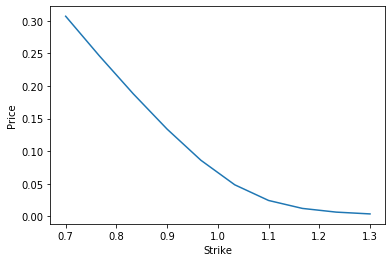

In [6]:
k_vec = np.linspace(0.7,1.3,10)
P_vec = np.zeros(len(k_vec))
for i,k_elem in enumerate(k_vec):
    for S_last in S_last_vec:
        P_vec[i] += max(0.0, S_last-k_elem)
    P_vec[i] /= len(S_last_vec)

plt.plot(k_vec,P_vec)
plt.xlabel('Strike')
plt.ylabel('Price')
P_vec

array([0.24645125, 0.23100668, 0.21328614, 0.19346674, 0.17364967,
       0.15725628, 0.14828494, 0.14784793, 0.15260564, 0.15965081])

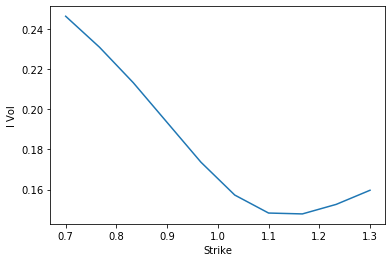

In [7]:
ivol_vec = np.zeros(len(k_vec))
for i,p in enumerate(P_vec):
    k = k_vec[i]
    res = calc_impl_vol(price = p, right = 'c', underlying = spot, strike = k, time = 1.0, rf = r)
    ivol_vec[i] = res.x[0]
    
plt.plot(k_vec,ivol_vec)
plt.xlabel('Strike')
plt.ylabel('I Vol')
ivol_vec